This notebook shows how to setup a new project, train a keypoint-MoSeq model and visualize the resulting syllables. You can load keypoint tracking results from SLEAP, DeepLabCut, or using your own custom format. We provide an [example DeepLabCut dataset](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link) that can be used for the tutorial.

# Colab setup

- Make a copy of this notebook if you plan to make changes and want them saved.
- Go to "Runtime">"change runtime type" and select "Python 3" and "GPU"

### Install keypoint MoSeq

In [ ]:
! pip install tensorflow==2.12.0
! pip install --upgrade "jax[cuda]==0.3.22" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
! pip install keypoint-moseq

import os
from google.colab import drive
drive.mount('/content/drive')

### Option 1: Use our example dataset

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1JGyS9MbdS3MtrlYnh4xdEQwe2bYoCuSZ'
output = 'dlc_example_project.zip'
gdown.download(url, output, quiet=False)
! unzip dlc_example_project.zip

data_dir = "dlc_example_project"

### Option 2: Use your own data
Upload your data to google drive and then change the following path as needed

In [ ]:
# data_dir = "/content/drive/MyDrive/MY_DATA_DIRECTORY"

# Project setup
Create a new project directory with a keypoint-MoSeq `config.yml` file.

In [3]:
import keypoint_moseq as kpms

project_dir = '/content/drive/MyDrive/demo_project/'
config = lambda: kpms.load_config(project_dir)

### Option 1: Setup from DeepLabCut

In [6]:
dlc_config = './dlc_example_project/config.yaml'
kpms.setup_project(project_dir, deeplabcut_config=dlc_config)

## Edit the config file

The config can be edited in a text editor or using the function `kpms.update_config`, as shown below. In general, the following parameters should be specified for each project:

- `bodyparts` (name of each keypoint; automatically imported from SLEAP/DeepLabCut)
- `use_bodyparts` (subset of bodyparts to use for modeling, set to all bodyparts by default; for mice we recommend excluding the tail)
- `anterior_bodyparts` and `posterior_bodyparts` (used for rotational alignment)
- `video_dir` (directory with videos of each experiment)

Edit the config as follows for the [example DeepLabCut dataset](https://drive.google.com/drive/folders/1UNHQ_XCQEKLPPSjGspRopWBj6-YNDV6G?usp=share_link):

In [7]:
kpms.update_config(
    project_dir,
    video_dir=os.path.join(data_dir, 'videos'),
    anterior_bodyparts=['nose'],
    posterior_bodyparts=['spine4'],
    use_bodyparts=[
        'spine4', 'spine3', 'spine2', 'spine1',
        'head', 'nose', 'right ear', 'left ear'])

## Load data

The code below shows how to load keypoint detections from DeepLabCut. To load other formats, replace `'deeplabcut'` in the example with one of `'sleap', 'anipose', 'sleap-anipose', 'nwb'`. For other formats, see the [FAQ](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#loading-keypoint-tracking-data).

In [8]:
# load data (e.g. from DeepLabCut)
keypoint_data_path = os.path.join(data_dir, 'videos') # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(keypoint_data_path, 'deeplabcut')

# format data for modeling
data, metadata = kpms.format_data(coordinates, confidences, **config())

Loading keypoints: 100%|████████████████| 10/10 [00:00<00:00, 11.91it/s]


## Calibration [disabled in colab]

The purpose of calibration is to learn the relationship between error and keypoint confidence scores. The resulting regression coefficients (`slope` and `intercept`) are used during modeling to set the noise prior on a per-frame, per-keypoint basis. **This step is disabled in colab**. In any case it can safely be skipped since the default parameters are fine for most datasets.  

## Fit PCA

Run the cell below to fit a PCA model to aligned and centered keypoint coordinates.

- The model is saved to ``{project_dir}/pca.p`` and can be reloaded using ``kpms.load_pca``.
- Two plots are generated: a cumulative [scree plot](https://en.wikipedia.org/wiki/Scree_plot) and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC.
- After fitting, edit `latent_dimension` in the config. This determines the dimension of the pose trajectory used to fit keypoint-MoSeq. A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower.  

>=90.0% of variance exlained by 4 components.


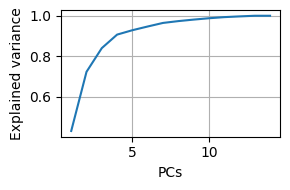

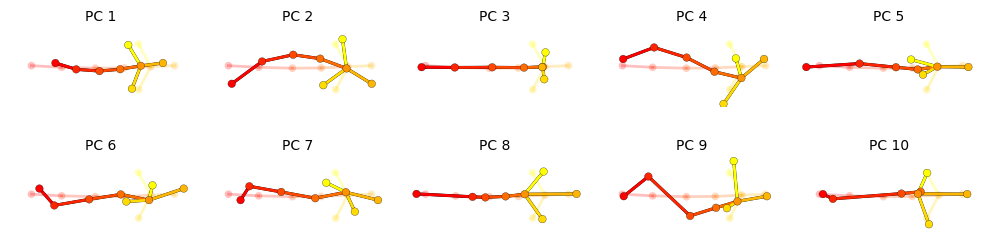

In [23]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.9)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, **config())

# use the following to load an already fit model
# pca = kpms.load_pca(project_dir)

In [24]:
kpms.update_config(project_dir, latent_dim=4)

Principal Component Analysis (PCA) is a statistical technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easier to explore and visualize. Here's how PCA relates to keypoints data from pose estimation:
1. **PCA Components**: Each principal component (PC) is a direction in the space of the original variables that represents the maximum variance (if you consider it as the first principal component) or the maximum variance under the constraint that it is orthogonal to the preceding components. For keypoints data, each PC would represent a combination of changes in the positions of the keypoints that together explain a large portion of the movement variation in the dataset.
2. **Iterpretation in Keypoint Data**:
- *Mean Pose*: This typically represents the average position of all keypoints across all frames or across a particular subset of the data. The mean pose is used as a reference or starting point.
- *Perturbation in the Direction of the PC*: This means that you are looking at how the keypoints move if you only allow them to move in the way described by a particular principal component. When you see a visualization that shows perturbation along a PC, it often means the keypoints are being displayed at some number of standard deviations along that PC from the mean pose. This shows you what kind of variation or movement that PC is capturing. In this context, showing the keypoints moving along the direction of a principal component can help you visualize the type of movement or variation that component represents.
3. **Figure Representation**:
The PCs themselves are abstract and do not correspond to actual physical movements but rather to statistical variations in the dataset.
When visualizing PCs in the context of pose estimation, often two poses are shown: one is the average pose (translucent), and the other is the average pose plus some multiple of the PC (solid), indicating the direction and magnitude of the movement captured by that PC.

In this context, this figure is showing what type of movement variation is most common (PC1), second most common (PC2), and so on, by showing you the keypoints move in the direction that represents that variation.


Keypoint MoSeq (Motion Sequencing) is a method for unsupervised identification and analysis of stereotyped, repeated motions, or "syllables" of behavior, from video data. The technique uses a combination of dimensionality reduction (like PCA) and a statistical model known as an autoregressive hidden Markov model (AR-HMM) to characterize and classify these motions. Here's a breakdown of the process and some of the terms involved:


# Model fitting

Fitting a keypoint-MoSeq model involves:
1. **Initialization:** Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.
2. **Fitting an AR-HMM (*Autoregressive Hidden Markov Model*):** The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling.
3. **Fitting the full model:** All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. pose trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.
4. **Extracting model results:** The learned states of the model are parsed and saved to disk for vizualization and downstream analysis.
4. **[Optional] Applying the trained model:** The learned model parameters can be used to infer a syllable sequences for additional data.

## Setting kappa

Most users will need to adjust the **kappa** hyperparameter to achieve the desired distribution of syllable durations. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). Most users will need to tune kappa to their particular dataset. Higher values of kappa lead to longer syllables. **You will need to pick two kappas: one for AR-HMM fitting and one for the full model.**
- We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.  
- Model fitting can be stopped at any time by interrupting the kernel, and then restarted with a new kappa value.
- The full model will generally require a lower value of kappa to yield the same target syllable durations.
- To adjust the value of kappa in the model, use `kpms.update_hypparams` as shown below. Note that this command only changes kappa in the model dictionary, not the kappa value in the config file. The value in the config is only used during model initialization.

## What is kappa hyperparameter?

The hyperparameter k (kappa) often relates to the duration of states or "syllables" that the model infers from the data. So it is a hyperparameter that influences the temporal granularity of the model, specifically how the model transitions between states over time. It typically controls the expected duration of each state by influencing the self-transition probabilities.
- Higher k Values: Lead to longer durations of states. The model is more likely to predict that the subject will remain in the same behavioral state for a longer period.
- Lower k Values: Result in shorter durations of states. The model is more flexible and transitions between states more frequently.

When fitting a model, you'll need to choose a value for kappa that makes sense for your specific dataset and the behaviors you're interested in. For instance, if you're studying behaviors that typically last for several seconds, you'll want a higher kappa to reflect that.

You may need to try several values of kappa, fitting the model each time, to find the best value that captures the natural durations of behaviors in your data. By observing how the model behaves with different kappa values, you can iteratively refine your choice to achieve a distribution of state durations that matches your expectations or the empirical distribution observed in your data.

In conclusion, kappa is a crucial hyperparameter for fine-tuning the temporal behavior of the model to ensure that the inferred state durations align with the biological or behavioral phenomena you're studying. It's a key part of the model-fitting process that can significantly affect the interpretability and accuracy of the results.

## Initialization

- Auto-regressive(AR) parameters: these are coefficients in the model that describe how the current pose can be predicted by a combination of previous poses.
- Syllable Sequences: These are the sequences of behavior units (like words in a sentence) that the model will try to identify. The term 'syllable' here is analogous to a discrete, repeatable movement pattern.

During initialization, these parameters and syllables sequences are set up based on the data, often using **random starting points**, and the PCA pose trajectories inform this initialization by providing a reduced-dimensionality space to work in.

In [25]:
# initialize the model
model = kpms.init_model(data, pca=pca, **config())

# optionally modify kappa
# model = kpms.update_hypparams(model, kappa=NUMBER)

## Fitting an AR-HMM

We're fitting an Autoregressive Model. This means that the model captures how the current pose of an animal can be predicted as a function of its previous poses. The AR component essentially says that the present is influenced by the past.

The Hidden Markov Model (HMM) is a statistical model in which the system being modeled is assumed to be a Markov process with unobserved (hidden) states. This model is particularly known in temporal pattern recognition, such as speech, handwritting, gesture recognition, etc.

In this context, the AR-HMM fitting phase focus on establishing the basic structure of the model: identifying hidden states (behavioral syllables), estimating the transition probabilities between different states, and setting up the autoregressive dynamics that describe how the system evolves over time.

In addition to fitting an AR-HMM, the function below:
- generates a name for the model and a corresponding directory in `project_dir`
- saves a checkpoint every 25 iterations from which fitting can be restarted
- plots the progress of fitting every 25 iterations, including
    - the distributions of syllable frequencies and durations for the most recent iteration
    - the change in median syllable duration across fitting iterations
    - a sample of the syllable sequence across iterations in a random window



Outputs will be saved to
/content/drive/MyDrive/demo_project/2023_11_05-12_28_24


 49%|█████████████████▏                 | 25/51 [02:57<02:41,  6.22s/it]

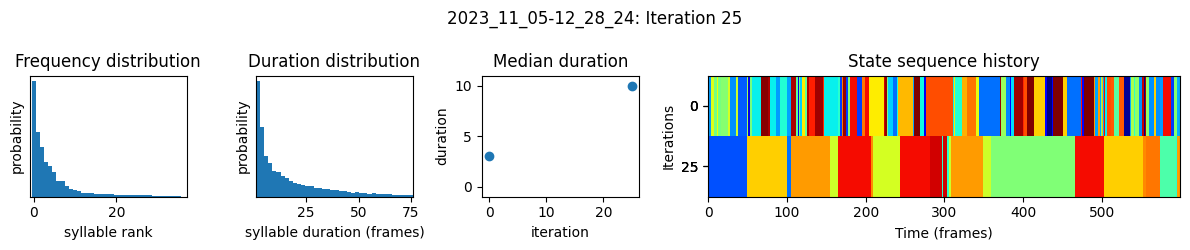

 98%|██████████████████████████████████▎| 50/51 [05:22<00:05,  5.27s/it]

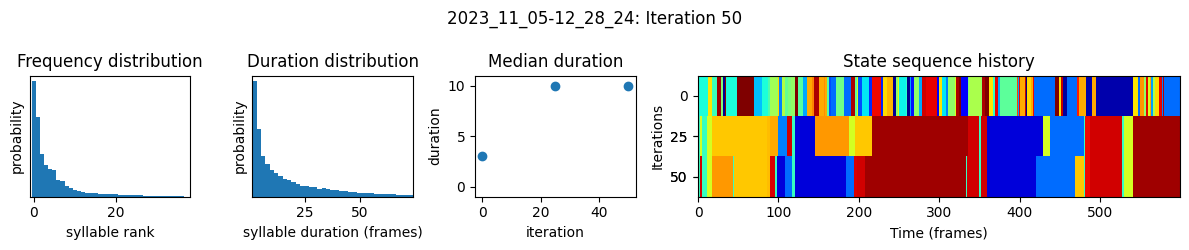

100%|███████████████████████████████████| 51/51 [05:31<00:00,  6.51s/it]


In [26]:
num_ar_iters = 50

model, model_name = kpms.fit_model(
    model, data, metadata, project_dir,
    ar_only=True, num_iters=num_ar_iters)

Let's try to understand these plots:
1. Frequency distribution: plotting probability vs syllable rank. This plot shows relative frequency of each syllable (or state) ocrruring in the dataset. Syllables are sorted from the most to last common. High-rank syllables are those that occurr very frequently.

2. Duration distribution: probability vs syllable duration. This histogram shows how each syllable typically lasts, measured in frames. This plot is useful for understanding the temporal characteristics of the behaviors being modeled. Whether they consist of quick, transient motions or longer sustaniend actions.

3. Median duration: this plot tracks the change in the median duration of syllables over the iterations of the model fitting process. As the model fitting proceeds, you would expect this value to stabilize, indicating that the mdoel has learned a consistent representation of the syllable durations in the data.

4. State sequence history: raster plot showing the sequence of syllable occurence over time as the model fitting progresses. Each row could represent an iteration of the model fitting, and the color or intensity of each point in the row indicates which syllable is present at that point in time. The plot gives you an overview of how the model's understanding of the temporal structure of the data evolves over time.

## Fitting the full model

After AR-HMM parameters are estimated, the full model fitting stages refines these estimates including additional parameters such as:
- Centroid and Heading: these parameters can describe the average position and orientation of the keypoints in each behavioral syllable.
- Noise estimates: these values account for variability in the data that isn't captured by the model's predictions.
- Continuous Latent States: These are the underlying continuous variables that the model estimates, which give a more nuanced view of the behavior.

So this full model fitting builds upon the AR-HMM and further refines the model by including these additional parameters. It's more comprehensive and typically requires more computational effort.

The following code fits a full keypoint-MoSeq model using the results of AR-HMM fitting for initialization. If using your own data, you may need to try a few values of kappa at this step.

Outputs will be saved to
/content/drive/MyDrive/demo_project/2023_11_05-12_28_24


  5%|█▌                              | 25/501 [08:01<1:36:52, 12.21s/it]

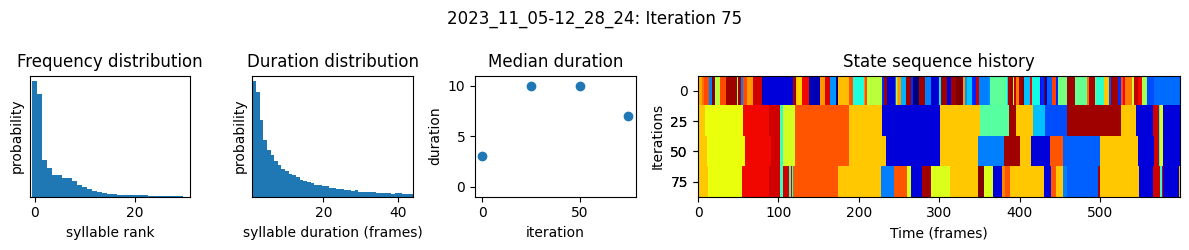

 10%|███▏                            | 50/501 [13:07<1:32:01, 12.24s/it]

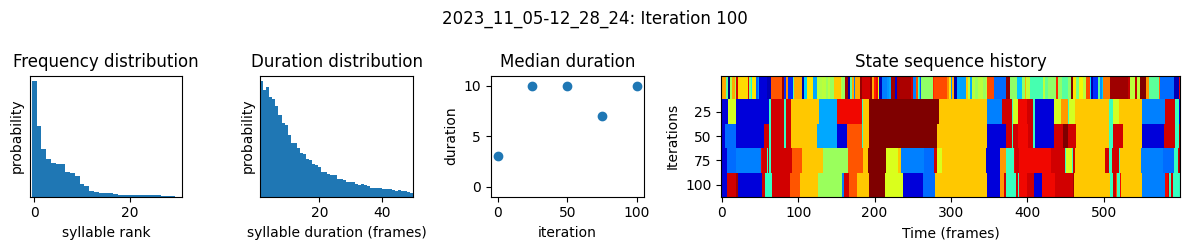

 15%|████▊                           | 75/501 [18:13<1:26:02, 12.12s/it]

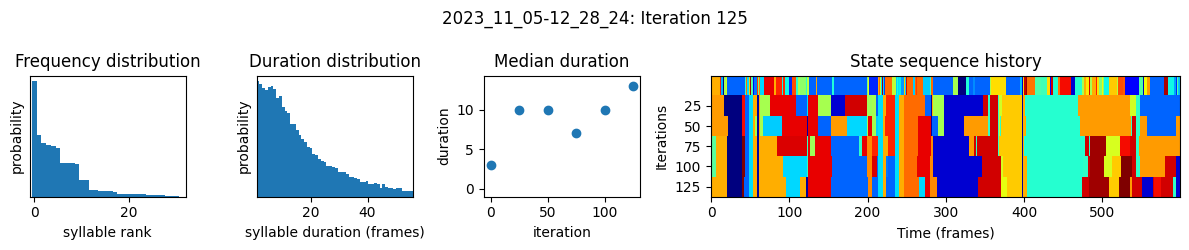

 20%|██████▏                        | 100/501 [23:36<1:24:17, 12.61s/it]

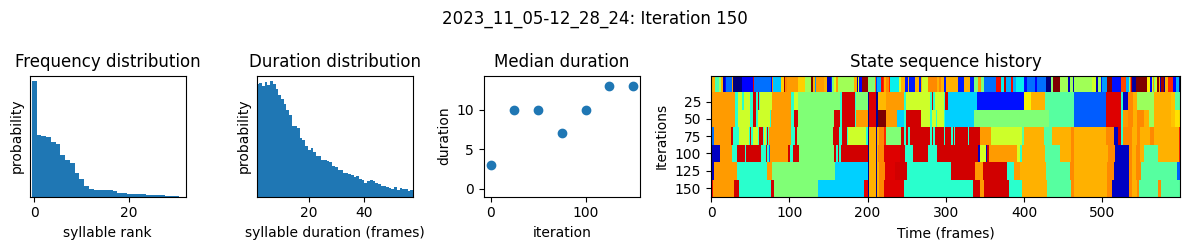

 25%|███████▋                       | 125/501 [28:50<1:16:19, 12.18s/it]

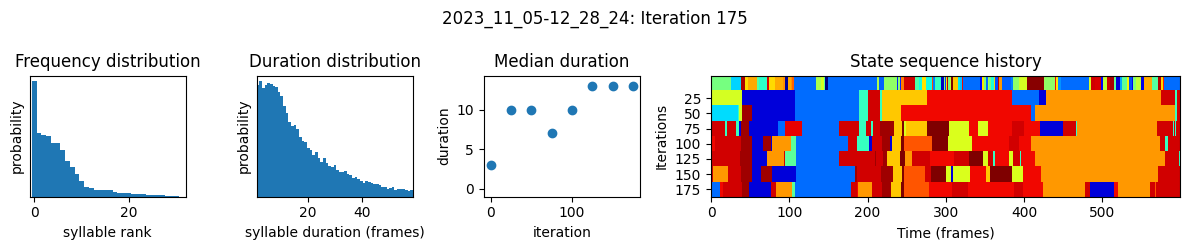

 30%|█████████▎                     | 150/501 [33:56<1:11:28, 12.22s/it]

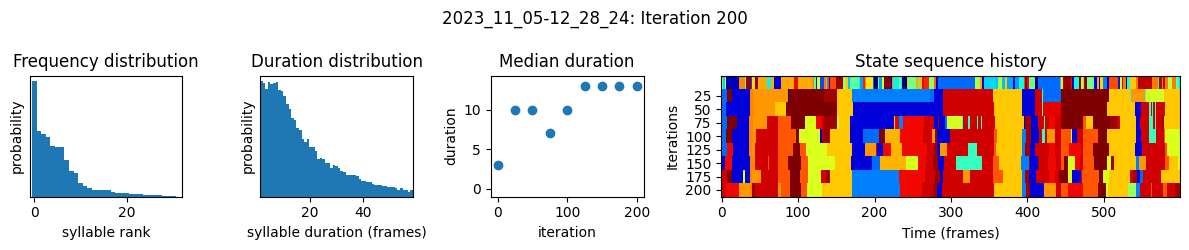

 35%|██████████▊                    | 175/501 [39:02<1:05:31, 12.06s/it]

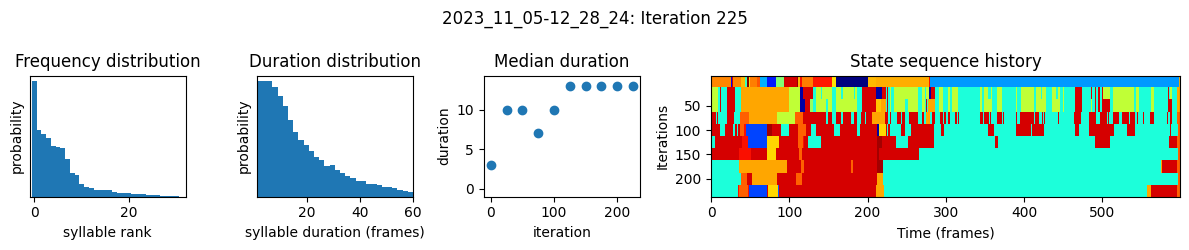

 40%|████████████▍                  | 200/501 [44:09<1:00:45, 12.11s/it]

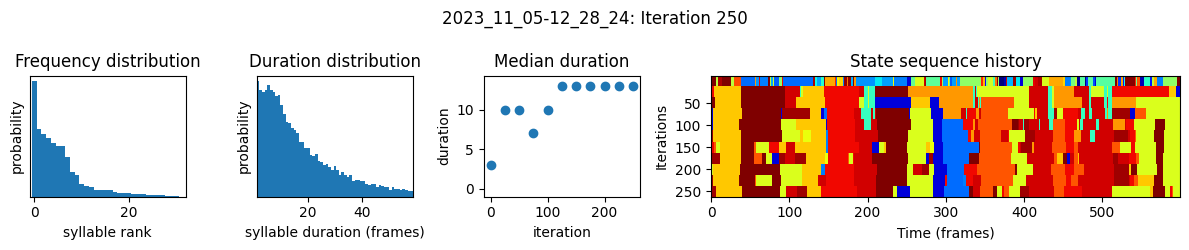

 45%|██████████████▊                  | 225/501 [49:15<56:07, 12.20s/it]

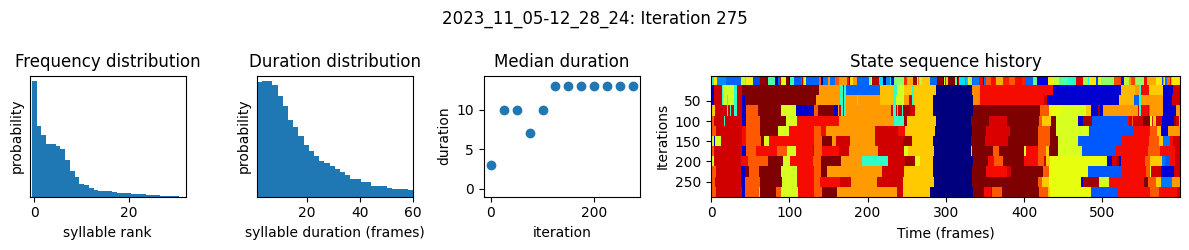

 50%|████████████████▍                | 250/501 [54:21<50:34, 12.09s/it]

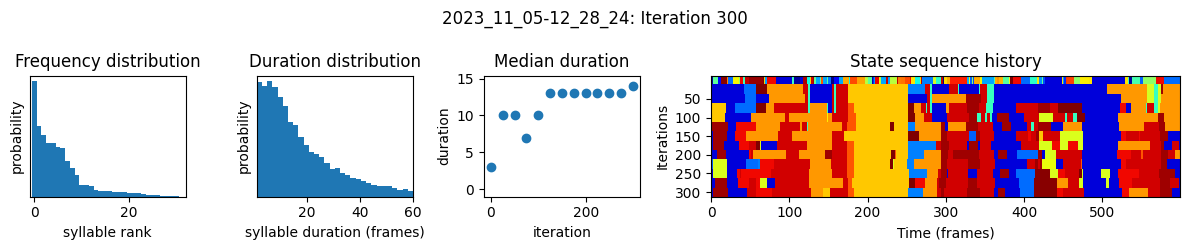

 55%|██████████████████               | 275/501 [59:28<45:54, 12.19s/it]

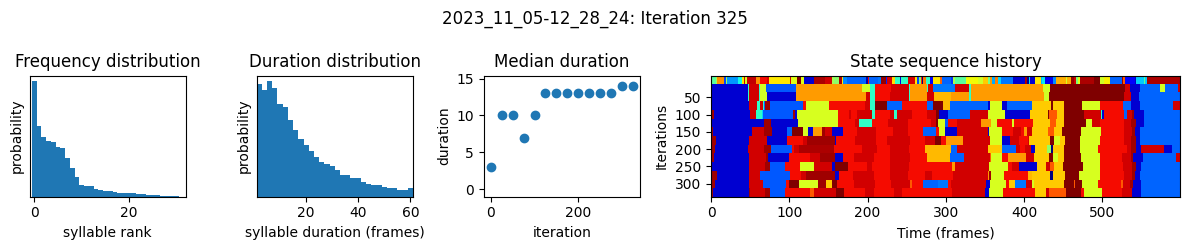

 60%|██████████████████▌            | 300/501 [1:04:37<41:08, 12.28s/it]

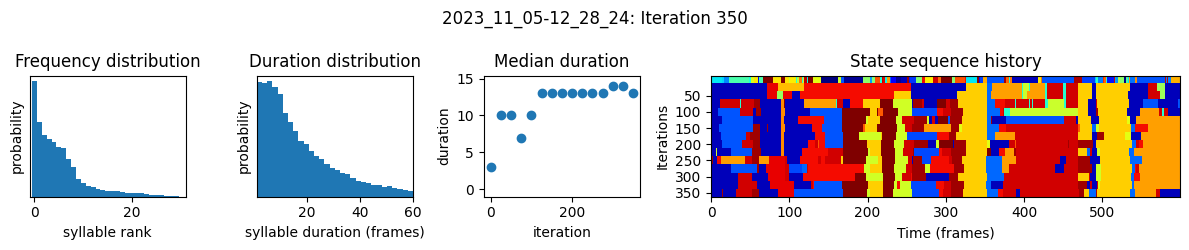

 65%|████████████████████           | 325/501 [1:09:44<35:47, 12.20s/it]

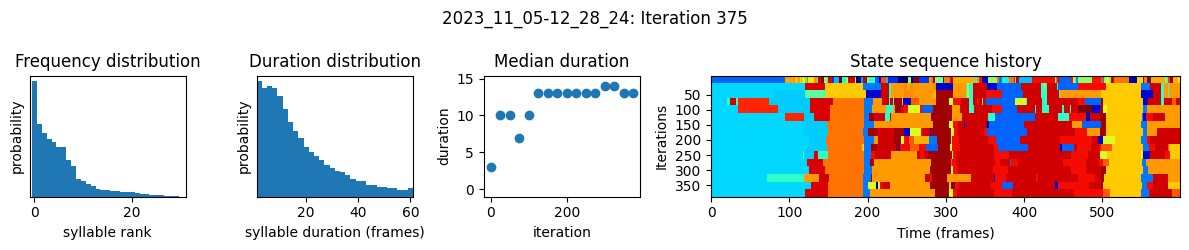

 70%|█████████████████████▋         | 350/501 [1:14:52<30:36, 12.16s/it]

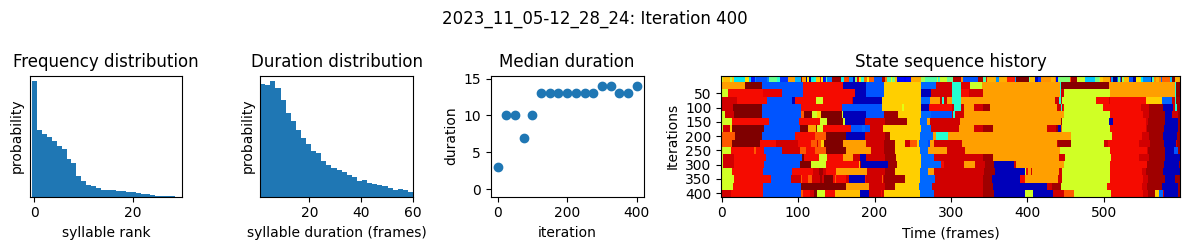

 75%|███████████████████████▏       | 375/501 [1:20:01<25:50, 12.31s/it]

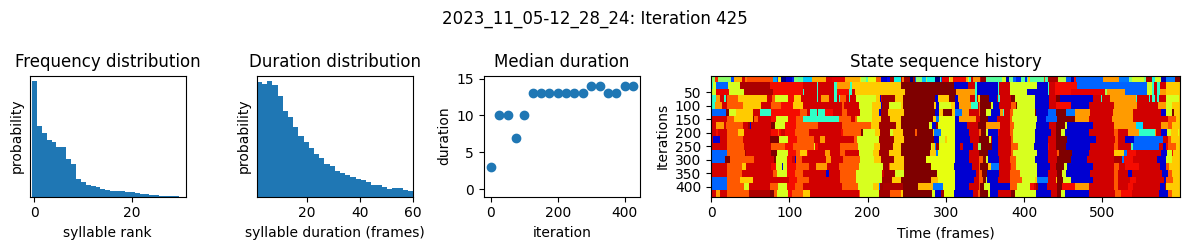

 80%|████████████████████████▊      | 400/501 [1:25:08<20:30, 12.19s/it]

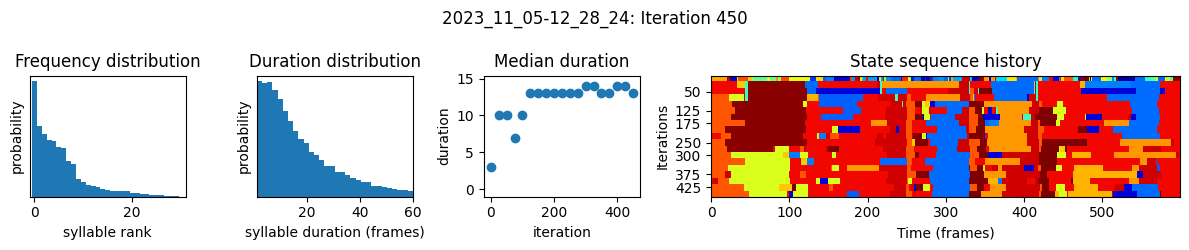

 85%|██████████████████████████▎    | 425/501 [1:30:17<15:34, 12.30s/it]

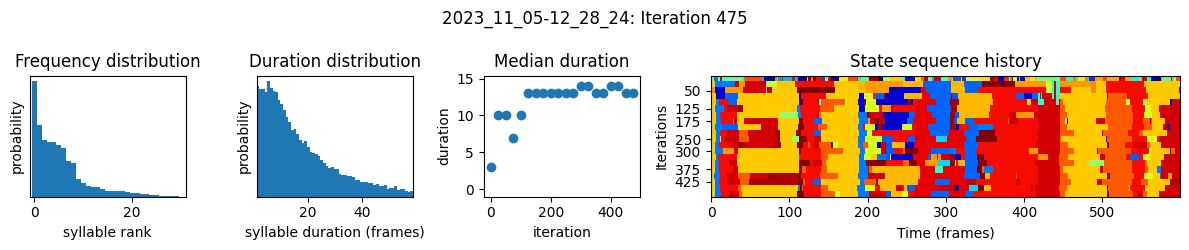

 90%|███████████████████████████▊   | 450/501 [1:35:25<10:30, 12.36s/it]

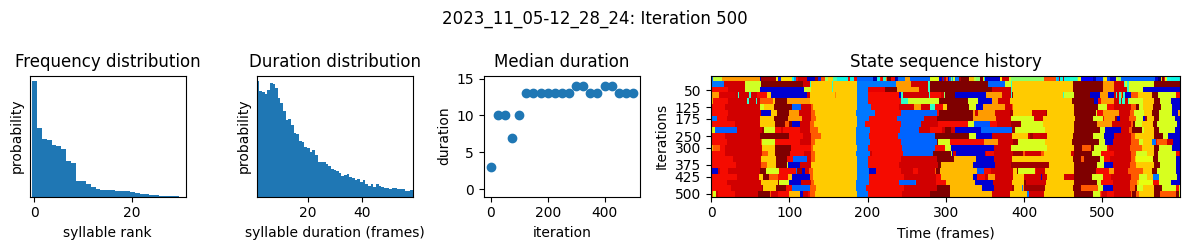

 95%|█████████████████████████████▍ | 475/501 [1:40:33<05:20, 12.32s/it]

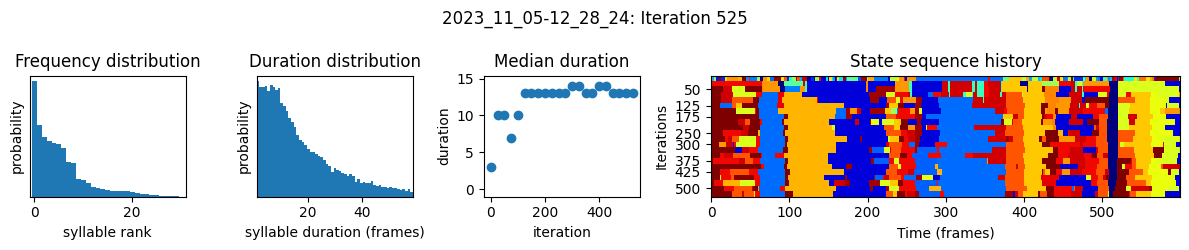

100%|██████████████████████████████▉| 500/501 [1:45:41<00:12, 12.17s/it]

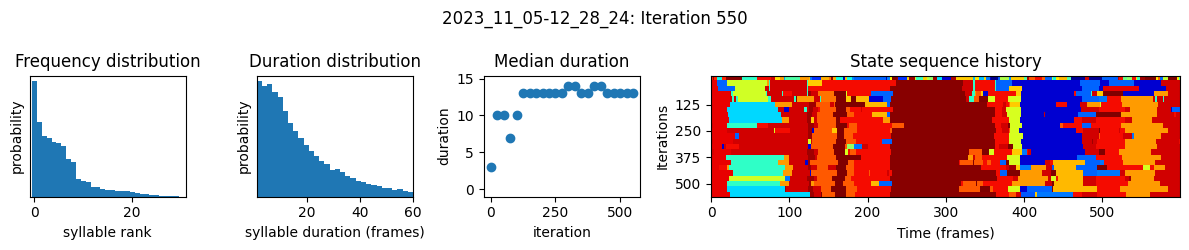

100%|███████████████████████████████| 501/501 [1:45:55<00:00, 12.69s/it]


In [27]:
# load model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e4)

# run fitting for an additional 200 iters
model = kpms.fit_model(
    model, data, metadata, project_dir, model_name, ar_only=False,
    start_iter=current_iter, num_iters=current_iter+500)[0]


## Sort syllables by frequency

Permute the states and parameters of a saved checkpoint so that syllables are labeled in order of frequency (i.e. so that `0` is the most frequent, `1` is the second most, and so on).


Sorting syllables by frequency after fitting the model is a post-processing step designed to make the interpretation and comparison of the model's output more intuitive

In [28]:
# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, model_name);

Reindexing: 100%|███████████| 23/23 [00:35<00:00,  1.53s/model snapshot]


```{warning}
Reindexing is only applied to the checkpoint file. Therefore, if you perform this step after extracting the modeling results or generating vizualizations, then those steps must be repeated.
```

## Extract model results

Parse the modeling results and save them to `{project_dir}/{model_name}/results.h5`. The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`. Check the docs for an [in-depth explanation of the modeling results](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#interpreting-model-outputs).
```
    results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

In [29]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, model_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name)

Saved results to
/content/drive/MyDrive/demo_project/2023_11_05-12_28_24/results.h5


### [Optional] Save results to csv

After extracting to an h5 file, the results can also be saved as csv files. A separate file will be created for each recording and saved to `{project_dir}/{model_name}/results/`.

In [30]:
# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

Saving to csv: 100%|████████████████████| 10/10 [00:06<00:00,  1.49it/s]


What do you find in the results file? It is typically a csv file containing following information on each column:
1. syllable: this column indicates the state of the syllable assigned to each frame or time point.
2. centroid x, centorid y: x,y coord of centroid of the subject
3. headings: orientation or direction that the subject is facing
4. latent_state0 to latent_state3: latent states or features extracted from the data that are not directly observable but have been inferred by the model. These latent states are hidden variables that the model infers from the data. These are not directly observable but are derived from the observable data. In this context, they represent various aspects of the animal's behavior that are consisten across the instances of the same behavior "syllable". For instance, even if the position of a mouse might change each time it performs a grooming behavior, the overall pattern of movement would be simillar. This patter can be captured in latent states. These latents allow the model to reduce the complexity of the data by capturing essential features that describe the behaviors. They give the model the power to predict future states and understand the structure of the data.


## Apply to new data

The code below shows how to apply a trained model to new data. This is useful if you have performed new experiments and would like to maintain an existing set of syllables. The results for the new experiments will be added to the existing `results.h5` file. **This step is optional and can be skipped if you do not have new data to add**.

In [ ]:
# load the most recent model checkpoint and pca object
# model = kpms.load_checkpoint(project_dir, model_name)[0]
# pca = kpms.load_pca(project_dir)

# # load new data (e.g. from deeplabcut)
# new_data = 'path/to/new/data/' # can be a file, a directory, or a list of files
# coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, 'deeplabcut')
# data, metadata = kpms.format_data(coordinates, confidences, **config())

# # apply saved model to new data
# results = kpms.apply_model(model, pca, data, metadata, project_dir, model_name, **config())

# optionally rerun `save_results_as_csv` to export the new results
# kpms.save_results_as_csv(results, project_dir, model_name)

# Visualization

## Trajectory plots
Generate plots showing the median trajectory of poses associated with each given syllable.

These plots are the way to see how the identified behaviors correspond to actual movement patterns.

Saving trajectory plots to /content/drive/MyDrive/demo_project/2023_11_05-12_28_24/trajectory_plots


Generating trajectory plots: 100%|██████| 22/22 [00:22<00:00,  1.04s/it]


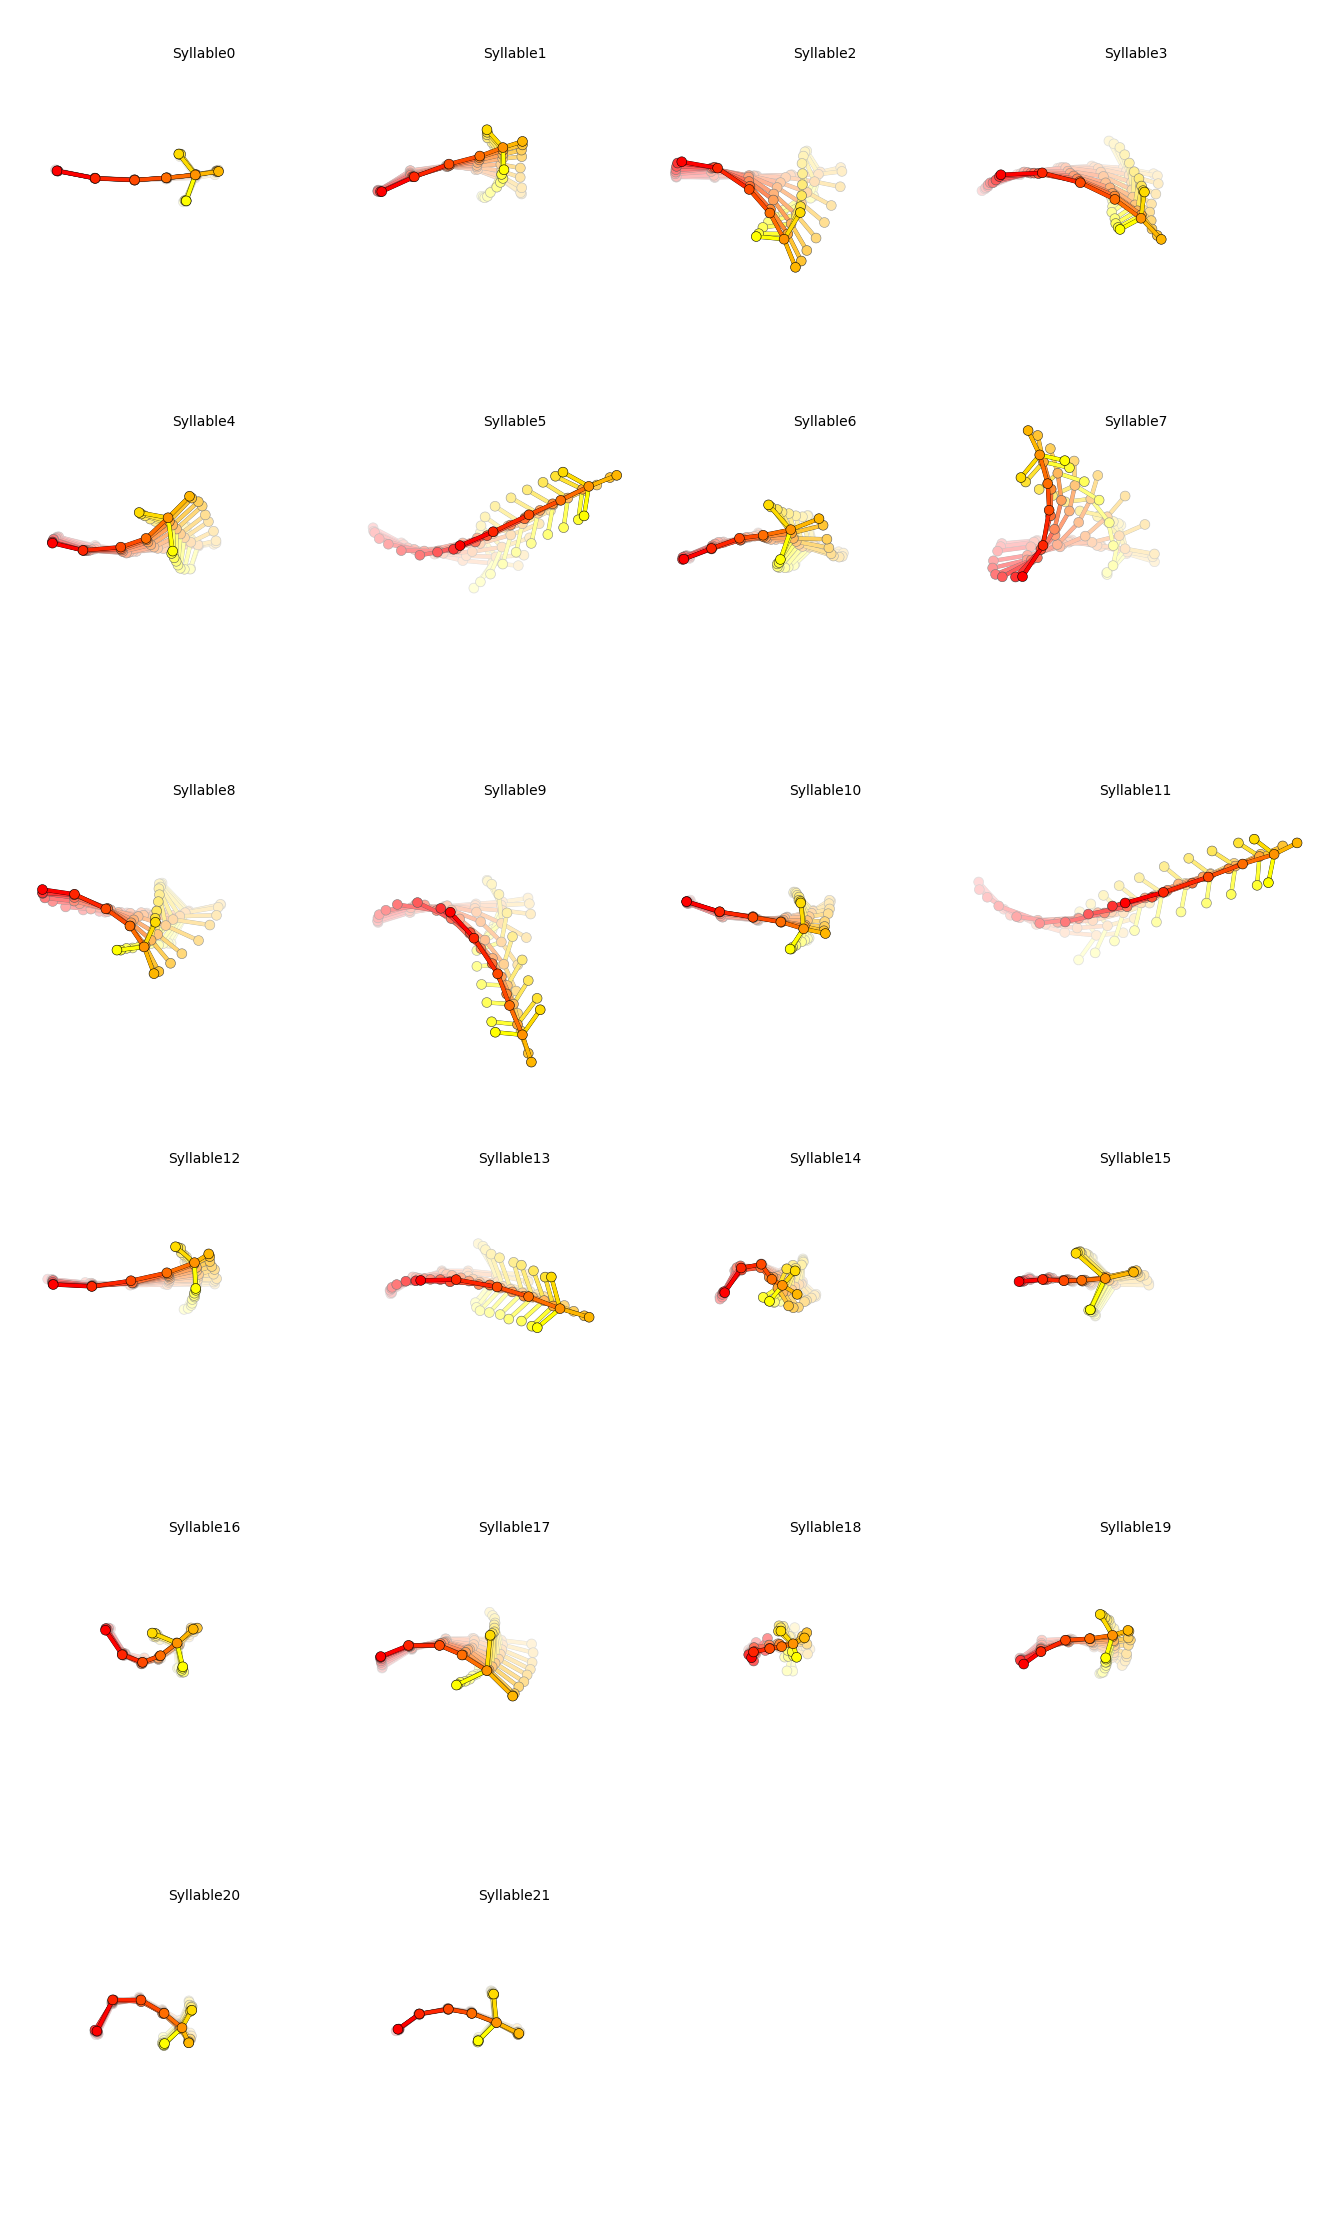

In [31]:
results = kpms.load_results(project_dir, model_name)
kpms.generate_trajectory_plots(coordinates, results, project_dir, model_name, **config())

## Grid movies
Generate video clips showing examples of each syllable.

In [32]:
kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, **config());

# for 3D data, include the flag `keypoints_only=True`
# kpms.generate_grid_movies(results, project_dir, model_name, coordinates=coordinates, keypoints_only=True, **config())

Writing grid movies to /content/drive/MyDrive/demo_project/2023_11_05-12_28_24/grid_movies


Generating grid movies: 100%|███████████| 22/22 [03:53<00:00, 10.63s/it]


## Syllable Dendrogram
Plot a dendrogram representing distances between each syllable's median trajectory.

Saving dendrogram plot to /content/drive/MyDrive/demo_project/2023_11_05-12_28_24/similarity_dendrogram


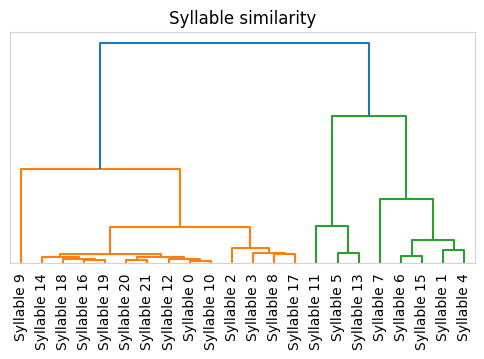

In [33]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, model_name, **config())